In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/train_X_csp.mat
/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/test_y.mat
/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/train_y.mat
/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/test_X_csp.mat


In [2]:
import scipy.io as sio
import torch
import numpy as np
import torch.utils.data as utils

In [3]:
path1='/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/train_X_csp.mat'
path2='/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/test_X_csp.mat'
path3='/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/test_y.mat'
path4='/kaggle/input/bandpassed-1014hz-splitted-data-75350-csp/train_y.mat'

train_X = sio.loadmat(path1)['train_X_csp']
train_y = sio.loadmat(path4)['train_y_csp']
 
test_X = sio.loadmat(path2)['test_X_csp']
test_y = sio.loadmat(path3)['test_y']

In [4]:
train_X.shape, test_X.shape

((275, 6, 9601), (275, 6, 2401))

In [5]:

train_X = np.moveaxis(train_X, [0, 1, 2], [-1, -2, -3])
train_X = np.expand_dims(train_X, axis=1)

test_X = np.moveaxis(test_X, [0, 1, 2], [-1, -2, -3])
test_X = np.expand_dims(test_X, axis=1)


In [6]:
train_X.shape, test_X.shape

((9601, 1, 6, 275), (2401, 1, 6, 275))

In [7]:
X_train_list = []
for i in range(len(train_X)):
    X_train_list.append(train_X[i])

In [8]:
X_test_list = []
for i in range(len(test_X)):
    X_test_list.append(test_X[i])

In [9]:
train_y = train_y.T
test_y = test_y.T

In [10]:
tensor_X_train = torch.stack([torch.FloatTensor(i) for i in X_train_list]) # transform to torch tensors
tensor_y_train = torch.Tensor(train_y)

In [11]:
tensor_X_test = torch.stack([torch.FloatTensor(i) for i in X_test_list]) # transform to torch tensors
tensor_y_test = torch.Tensor(test_y)

In [12]:
train_dataset = utils.TensorDataset(tensor_X_train,tensor_y_train)
train_loader = utils.DataLoader(train_dataset, batch_size=128, num_workers=1)

In [13]:
test_dataset = utils.TensorDataset(tensor_X_test,tensor_y_test)
test_loader = utils.DataLoader(test_dataset, batch_size=128, num_workers=1)

In [14]:
import torch.nn.functional as F
from torch import nn
class Tor4(nn.Module):
    def __init__(self):
        super(Tor4, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.fc1 = nn.Linear(64*6*275, 10)
        self.fc2 = nn.Linear(10,2)
        
    def forward(self, x):
        x=self.conv1(x)
        x=F.relu(x)
        x=self.conv2(x)
        x=F.relu(x)
        x = x.view(-1, 64*6*275)
        x=F.relu(x)
        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)

        
        return x
net = Tor4()

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Tor4(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=105600, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [16]:
from torch import nn
from torch import optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [17]:
import tqdm
from sklearn.metrics import accuracy_score

In [18]:
from sklearn.metrics import roc_auc_score
num_epochs = 100
acc_train = []
loss_train = []

acc_test = []
loss_test = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    acc=0
    for i, data in enumerate(train_loader, 0):
        net.train()
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data[0].to(device), data[1].to(device)       # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        acc += accuracy_score(outputs.max(dim=1)[1].cpu().numpy(), labels.max(dim=1)[1].cpu().numpy())

           # print every epoch
    print("epoch: {}, training loss: {} training accuracy: {}".format(epoch+1, running_loss/76, acc/76))
    acc_train.append(acc/75)
    loss_train.append(running_loss/75)
    auc1 = 0
    auc2 = 0
    with torch.no_grad():
        net.eval()
        test_loss = 0
        accuracy=0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            accuracy += accuracy_score(outputs.max(dim=1)[1].cpu().numpy(), labels.max(dim=1)[1].cpu().numpy())
        print("epoch: {}, testing loss: {}, testing accuracy:{}".format(epoch+1, test_loss/18.76, accuracy/18.76))
        
        acc_test.append(accuracy/18.76)
        loss_test.append(test_loss/18.76)

epoch: 1, training loss: 0.6918427450092215 training accuracy: 0.5374177631578947
epoch: 1, testing loss: 0.6977244576157282, testing accuracy:0.5493161379223177


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 2, training loss: 0.6860284452375612 training accuracy: 0.5614720394736842
epoch: 2, testing loss: 0.6915165131280162, testing accuracy:0.5853793784208559
epoch: 3, training loss: 0.680556196915476 training accuracy: 0.5795641447368421
epoch: 3, testing loss: 0.6864888962906306, testing accuracy:0.6129806371309872
epoch: 4, training loss: 0.6756224655791333 training accuracy: 0.5909745065789473
epoch: 4, testing loss: 0.6819500979075808, testing accuracy:0.6242074673576153
epoch: 5, training loss: 0.6711249131905405 training accuracy: 0.6060855263157895
epoch: 5, testing loss: 0.6776425280550649, testing accuracy:0.6321199140527113
epoch: 6, training loss: 0.6662374852519286 training accuracy: 0.6075246710526315
epoch: 6, testing loss: 0.6724732072114435, testing accuracy:0.6336354288022332
epoch: 7, training loss: 0.6609598421736768 training accuracy: 0.6163651315789473
epoch: 7, testing loss: 0.6676861789943312, testing accuracy:0.6286380940474358
epoch: 8, training loss: 0.65

epoch: 52, testing loss: 0.6255087885521113, testing accuracy:0.6634691738289407
epoch: 53, training loss: 0.59280186190613 training accuracy: 0.6756784539473685
epoch: 53, testing loss: 0.6253555353516455, testing accuracy:0.6648515980480513
epoch: 54, training loss: 0.5922053555320752 training accuracy: 0.6753700657894737
epoch: 54, testing loss: 0.6252833076123235, testing accuracy:0.6648515980480513
epoch: 55, training loss: 0.5916139579034949 training accuracy: 0.6766036184210527
epoch: 55, testing loss: 0.6251821226910995, testing accuracy:0.6661009317367507
epoch: 56, training loss: 0.5910367078490948 training accuracy: 0.6761924342105263
epoch: 56, testing loss: 0.6250931637119382, testing accuracy:0.6661009317367507
epoch: 57, training loss: 0.5904711054539994 training accuracy: 0.6769120065789473
epoch: 57, testing loss: 0.6249441139733612, testing accuracy:0.6656844871738509
epoch: 58, training loss: 0.5898965018752375 training accuracy: 0.6773231907894737
epoch: 58, testing

In [19]:
epochs = list(range(1,num_epochs+1))

In [20]:
import matplotlib.pyplot as plt

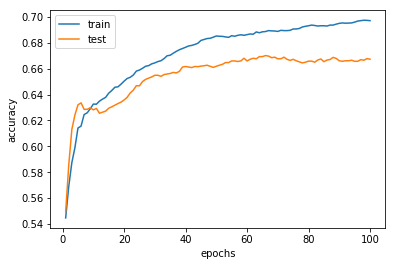

In [21]:
plt.plot(epochs,acc_train,label='train')
plt.plot(epochs,acc_test, label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

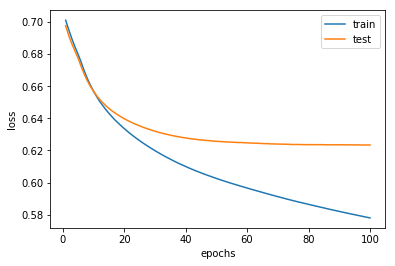

In [22]:
plt.plot(epochs,loss_train,label='train')
plt.plot(epochs,loss_test, label='test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [24]:
import sklearn.metrics as metrics

In [47]:
net.eval()
testy = []
lr_probs = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        testy.extend(labels)
        lr_probs.extend(nn.functional.softmax(outputs,dim=1).cpu().numpy())

In [63]:
y_pred = np.asarray(lr_probs)

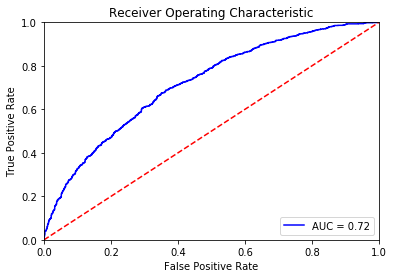

In [69]:
fpr, tpr, threshold = metrics.roc_curve(test_y.T[0], y_pred.T[0])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

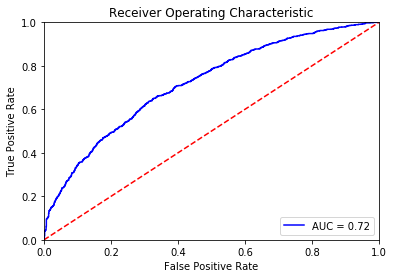

In [68]:
fpr, tpr, threshold = metrics.roc_curve(test_y.T[1], y_pred.T[1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()